In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import os
import sys
sys.path.append('/home/vaschetti/maxarSrc/datasets_and_samplers')
from myGeoDatasets import Maxar
from mySamplers import MyGridGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
from samplers_utils import boundingBox_2_Polygon
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
import supervision as sv
import torch
from time import time

In [2]:
dataset = Maxar('/mnt/data2/vaschetti_data/maxar/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031213.tif')
size = 608
sampler = MyGridGeoSampler(dataset, size=size, stride=size)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
data_crs = dataset.crs

from build_seg_utils import building_gdf
gdfs_32628 = building_gdf('TheGambia', dataset_crs = data_crs)
index_MS_buildings = gdfs_32628.sindex

Found 6 links for TheGambia


In sampler
tile_polygon:  POLYGON ((320156.25 1489843.75, 315455.322265625 1489843.75, 315470.63516642543 1492342.8892077415, 320156.25 1491748.5059546148, 320156.25 1489843.75))
In plot
Crs EPSG:32628
sx_low:  (317998.046875, 1489843.75)
dx_high:  (318183.59375, 1490029.296875)


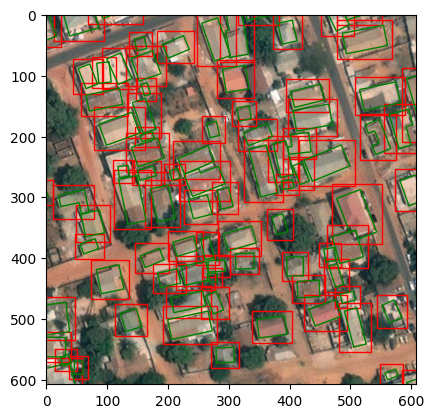

In [3]:
from random import randint
from build_seg_utils import rel_bbox_coords, rel_polyg_coord
dataset_res = dataset.res
i = 0
for batch in dataloader:
    query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0])
    hits = index_MS_buildings.query(query_bbox_poly)
    if len(hits) > 10: #per prendere immagini con almeno X edifici
        i+=1
        if i == 10 :#randint(0, 20): #per prendere immagini random
            sample = unbind_samples(batch)[0]
            img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')
            
            #predictor.set_image(img4Sam) #encoding the image

            #Getting the relative coordinates of the buildings boxes
            building_boxes = rel_bbox_coords(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res, ext_mt=5)

            #Plotting
            fig, ax = dataset.plot(sample)   
            for box in building_boxes:
                x0, y0 = box[0], box[1]
                w, h = box[2] - box[0], box[3] - box[1]
                rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
                ax.add_patch(rect)
            for rel_pol in rel_polyg_coord(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res):
                poly = patches.Polygon(rel_pol, linewidth=1, edgecolor='g', facecolor='none')
                ax.add_patch(poly)

            break

## SAM

In [4]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/vaschetti/maxarSrc/creating_labels/models/SAM/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device='cuda:1')

SAMpredictor = SamPredictor(sam)

In [5]:
t_0_Sam = time()
SAMpredictor.set_image(img4Sam)

#prepare the data for the model
building_boxes_t = torch.tensor(building_boxes, device=SAMpredictor.device)

#Given the box coorindates as xyxy return the center of the rectangle
point_coords = torch.tensor([[(sublist[0] + sublist[2])/2, (sublist[1] + sublist[3])/2] for sublist in building_boxes_t], device=SAMpredictor.device)
point_labels = torch.tensor([1] * point_coords.shape[0], device=SAMpredictor.device)
transformed_points = SAMpredictor.transform.apply_coords_torch(point_coords, img4Sam.shape[:2]).unsqueeze(1)
transformed_boxes = SAMpredictor.transform.apply_boxes_torch(building_boxes_t, img4Sam.shape[:2])

SAMmasks, _, _ = SAMpredictor.predict_torch(
                point_coords=None,
                point_labels=None,
                boxes=transformed_boxes,
                multimask_output=False,
            )
t_1_Sam = time() - t_0_Sam

## FastSAM

In [6]:
sys.path.append('/home/vaschetti/maxarSrc/creating_labels/models/')
from FastSAM.fastsam import FastSAM, FastSAMPrompt
from FastSAM.utils.tools import convert_box_xywh_to_xyxy

model_path = '/home/vaschetti/maxarSrc/creating_labels/models/FastSAM/weights/FastSAM-x.pt'
model = FastSAM(model_path)

In [7]:
device = 'cuda:1'
t_0_FastSam = time()
everything_results = model(
        img4Sam,
        device= device,
        imgsz=img4Sam.shape[0],
        )


0: 608x608 115 objects, 38.0ms
Speed: 5.5ms preprocess, 38.0ms inference, 53.3ms postprocess per image at shape (1, 3, 608, 608)


In [8]:
bboxes = None
points = None
point_label = None
prompt_process = FastSAMPrompt(img4Sam, everything_results, device=device)

box_prompt = building_boxes
if box_prompt[0][2] != 0 and box_prompt[0][3] != 0:
    FSAMmasks = prompt_process.box_prompt(bboxes=box_prompt)
    bboxes = box_prompt
t_1_FastSam = time() - t_0_FastSam

## EFFICIENT SAM

In [9]:
sys.path.append('/home/vaschetti/maxarSrc/creating_labels/models/EfficientSAM_old')
from efficient_sam import build_efficient_sam
from torchvision import transforms


ImportError: cannot import name 'build_efficient_sam' from 'efficient_sam' (unknown location)

In [ ]:
# Build the model.
ESAM_device = 'cuda:1'
ESAM_root = '/home/vaschetti/maxarSrc/creating_labels/models/EfficientSAM_old'
efficient_sam = build_efficient_sam(os.path.join(ESAM_root, 'weights/efficient_sam_vitt.pth'), device=ESAM_device)
efficient_sam.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (proj): Linear(in_features=192, out_features=192, bias=True)
        )
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=768, out_features=192, bias=True)
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )
  )
  (pro

In [ ]:
# load an image
sample_image_np = img4Sam
sample_image_tensor = transforms.ToTensor()(sample_image_np)
sample_image_tensor = sample_image_tensor.to(ESAM_device)

t_build_boxes = torch.tensor(building_boxes, device=ESAM_device)
print('building boxes:', t_build_boxes.shape)
ESAM_boxes = t_build_boxes.unsqueeze(0)
ESAM_boxes = ESAM_boxes.reshape(-1,2,2)
print('ESAM_boxes:', ESAM_boxes.shape)

input_points = ESAM_boxes.unsqueeze(0) #[B, max_num_queries, num_pts, 2] = [B, #boxes, 2, 2] unsqueeze to add the batch dim
input_labels = torch.tensor([[[2,3]]*input_points.shape[1]], device=ESAM_device) #[B, max_num_queries, num_pts]

print(input_points.shape)
print(input_labels.shape)

building boxes: torch.Size([86, 4])
ESAM_boxes: torch.Size([86, 2, 2])
torch.Size([1, 86, 2, 2])
torch.Size([1, 86, 2])


In [ ]:
t_0_ESAM = time()
predicted_logits, predicted_iou = efficient_sam(
    sample_image_tensor[None, ...],
    input_points,
    input_labels,
)
ESAM_mask = torch.ge(predicted_logits[0, :, 0], 0).cpu().detach().numpy().any(axis=0)
t_1_ESAM = time() - t_0_ESAM

OutOfMemoryError: CUDA out of memory. Tried to allocate 344.00 MiB. GPU 1 has a total capacty of 10.92 GiB of which 117.81 MiB is free. Including non-PyTorch memory, this process has 10.79 GiB memory in use. Of the allocated memory 10.38 GiB is allocated by PyTorch, and 247.80 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## New Efficient SAM

In [9]:
import os
import sys
sys.path.append('/home/vaschetti/maxarSrc/creating_labels/models/EfficientSAM')
os.chdir('/home/vaschetti/maxarSrc/creating_labels/models/EfficientSAM')
from efficient_sam.build_efficient_sam import build_efficient_sam_vitt, build_efficient_sam_vits
from PIL import Image
from torchvision import transforms
import torch
import numpy as np
import zipfile

In [14]:
os.chdir('/home/vaschetti/maxarSrc/creating_labels/models/EfficientSAM')
ESAM_device = 'cuda:2'
models = {}

root = '/home/vaschetti/maxarSrc/creating_labels/models/EfficientSAM'

models['efficientsam_ti'] = build_efficient_sam_vitt().to(ESAM_device)

# Since EfficientSAM-S checkpoint file is >100MB, we store the zip file.
with zipfile.ZipFile(os.path.join(root,"weights/efficient_sam_vits.pt.zip"), 'r') as zip_ref:
    zip_ref.extractall("weights")
# # Build the EfficientSAM-S model.
models['efficientsam_s'] = build_efficient_sam_vits().to(ESAM_device)

In [15]:
# load an image
sample_image_np = img4Sam
sample_image_tensor = transforms.ToTensor()(sample_image_np)
sample_image_tensor = sample_image_tensor.to(ESAM_device)

t_build_boxes = torch.tensor(building_boxes, device=ESAM_device)
print('building boxes:', t_build_boxes.shape)
ESAM_boxes = t_build_boxes.unsqueeze(0)
ESAM_boxes = ESAM_boxes.reshape(-1,2,2)
print('ESAM_boxes:', ESAM_boxes.shape)

input_points = ESAM_boxes.unsqueeze(0) #[B, max_num_queries, num_pts, 2] = [B, #boxes, 2, 2] unsqueeze to add the batch dim
input_labels = torch.tensor([[[2,3]]*input_points.shape[1]], device=ESAM_device) #[B, max_num_queries, num_pts]

print(input_points.shape)
print(input_labels.shape)

building boxes: torch.Size([86, 4])
ESAM_boxes: torch.Size([86, 2, 2])
torch.Size([1, 86, 2, 2])
torch.Size([1, 86, 2])


In [16]:
model_name = 'efficientsam_ti'
print('Running inference using ', model_name)
t_0_ESAM = time()
predicted_logits, predicted_iou = models[model_name](
        sample_image_tensor[None, ...],
        input_points,
        input_labels,
    )
t_1_ESAM = time() - t_0_ESAM
print('Time taken: ', t_1_ESAM)
#ESAM_mask = torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy().any(axis=0)
ESAM_mask = torch.ge(predicted_logits[0, :, 0], 0).cpu().detach().numpy().any(axis=0)

#masked_image_np = sample_image_np.copy().astype(np.uint8) * ESAM_mask[:,:,None]


Running inference using  efficientsam_ti


OutOfMemoryError: CUDA out of memory. Tried to allocate 688.00 MiB. GPU 2 has a total capacty of 10.92 GiB of which 294.31 MiB is free. Including non-PyTorch memory, this process has 10.61 GiB memory in use. Of the allocated memory 10.41 GiB is allocated by PyTorch, and 27.80 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [20]:
ESAM_mask = torch.ge(predicted_logits[0, :, 0], 0).cpu().detach().numpy().any(axis=0)

In [ ]:
for model_name, efficient_sam in models.items():
    print('Running inference using ', model_name)
    t_0 = time()
    predicted_logits, predicted_iou = efficient_sam(
        sample_image_tensor[None, ...],
        input_points[:,:5],
        input_labels[:,:5],
    )
    print('Time taken: ', time() - t_0)
    # The masks are already sorted by their predicted IOUs.
    # The first dimension is the batch size (we have a single image. so it is 1).
    # The second dimension is the number of masks we want to generate (in this case, it is only 1)
    # The third dimension is the number of candidate masks output by the model.
    # For this demo we use the first mask.
    mask = torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()
    masked_image_np = sample_image_np.copy().astype(np.uint8) * mask[:,:,None]
    break

Running inference using  efficientsam_ti
Time taken:  0.08912014961242676


In [ ]:
t_0_ESAM = time()
print(sample_image_tensor.device)
print(input_points.device)
print(input_labels.device)
predicted_logits, predicted_iou = models['efficientsam_s'](
    sample_image_tensor[None, ...],
    input_points,
    input_labels,
)
ESAM_mask = torch.ge(predicted_logits[0, :, 0], 0).cpu().detach().numpy().any(axis=0)
t_1_ESAM = time() - t_0_ESAM

cuda:0
cuda:0
cuda:0


OutOfMemoryError: CUDA out of memory. Tried to allocate 172.00 MiB. GPU 0 has a total capacty of 10.92 GiB of which 107.81 MiB is free. Including non-PyTorch memory, this process has 10.80 GiB memory in use. Of the allocated memory 10.45 GiB is allocated by PyTorch, and 190.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Plotting Results

In [13]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=75):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='y', marker='.', s=marker_size, edgecolor='white', linewidth=0.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=0.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='r', facecolor=(0,0,0,0), lw=0.5))

def plot_w_wo_masks_SAM(img, masks, boxes = None):
    
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)

    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    for mask in masks:
        show_mask(mask.cpu().numpy(), ax2)
    if boxes is not None:
        for box in boxes:
            show_box(box.cpu().numpy(), ax2)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])

    ax1.axis('off')
    ax2.axis('off')

def plot_w_wo_masks_FSAM(img, masks, building_boxes = None):
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)

    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    for mask in masks:
        show_mask(mask, ax2)
    if building_boxes is not None:
        for box in building_boxes:
            x0, y0 = box[0], box[1]
            w, h = box[2] - box[0], box[3] - box[1]
            rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
            ax2.add_patch(rect)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])

    ax1.axis('off')
    ax2.axis('off')

def plot_w_wo_masks_ESAM(img, masks, building_boxes = None):
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)

    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    if masks.ndim == 2:
        masks = masks[np.newaxis, ...]
    for mask in masks:
        show_mask(mask, ax2)
    if building_boxes is not None:
        for box in building_boxes:
            x0, y0 = box[0], box[1]
            w, h = box[2] - box[0], box[3] - box[1]
            rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
            ax2.add_patch(rect)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])

    ax1.axis('off')
    ax2.axis('off')


def show_points(coords, labels, ax, marker_size=75):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='y', marker='.', s=marker_size, edgecolor='white', linewidth=0.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=0.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='r', facecolor=(0,0,0,0), lw=0.5))

def plot_w_wo_masks_SAM(img, masks, boxes = None):
    
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)

    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    if masks.ndim == 2:
        masks = masks[np.newaxis, ...]
    for mask in masks:
        show_mask(mask.cpu().numpy(), ax2)
    if boxes is not None:
        for box in boxes:
            show_box(box.cpu().numpy(), ax2)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])

    ax1.axis('off')
    ax2.axis('off')

def plot_w_wo_masks_FSAM(img, masks, building_boxes = None):
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)

    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    for mask in masks:
        show_mask(mask, ax2)
    if building_boxes is not None:
        for box in building_boxes:
            x0, y0 = box[0], box[1]
            w, h = box[2] - box[0], box[3] - box[1]
            rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
            ax2.add_patch(rect)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])

    ax1.axis('off')
    ax2.axis('off')

def SAMvsFSAM(img, SAM_masks, FSAM_masks, SAM_time = '', FastSAM_time = ''):
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 3, 2)
    #img
    ax1.imshow(img)
    ax1.set_title('Original')

    #SAM
    ax2 = fig.add_subplot(1, 3, 1, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    for mask in SAM_masks:
        show_mask(mask.cpu().numpy(), ax2)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])
    ax2.set_title('SAM: ' + str(round(SAM_time, 2)) + ' (s)')

    #FastSAM
    ax3 = fig.add_subplot(1, 3, 3, sharex=ax1, sharey=ax1)
    ax3.imshow(img)
    for mask in FSAM_masks:
        show_mask(mask, ax3)
    ax3.set_xlim([0, img.shape[1]])
    ax3.set_ylim([img.shape[0], 0])
    ax3.set_title('FastSAM: ' + str(round(FastSAM_time,2)) + ' (s)')

    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')




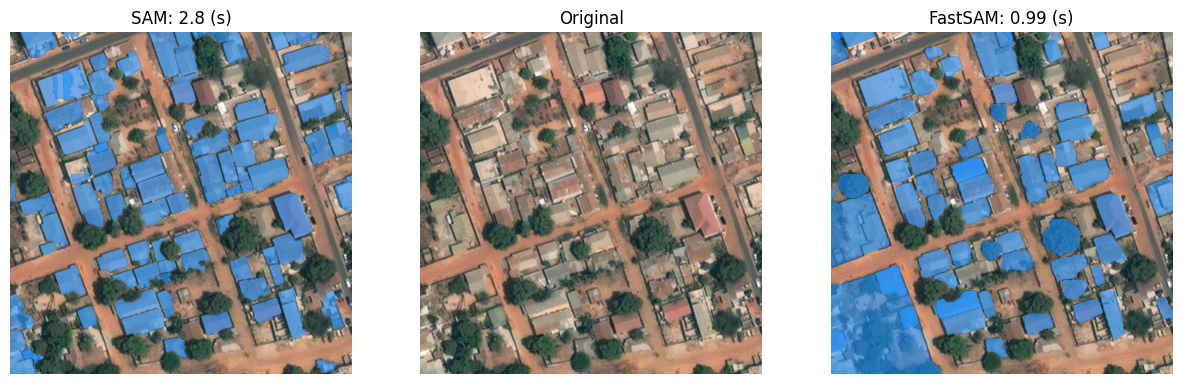

In [14]:
SAMvsFSAM(img4Sam, SAMmasks, FSAMmasks, SAM_time = t_1_Sam, FastSAM_time = t_1_FastSam)

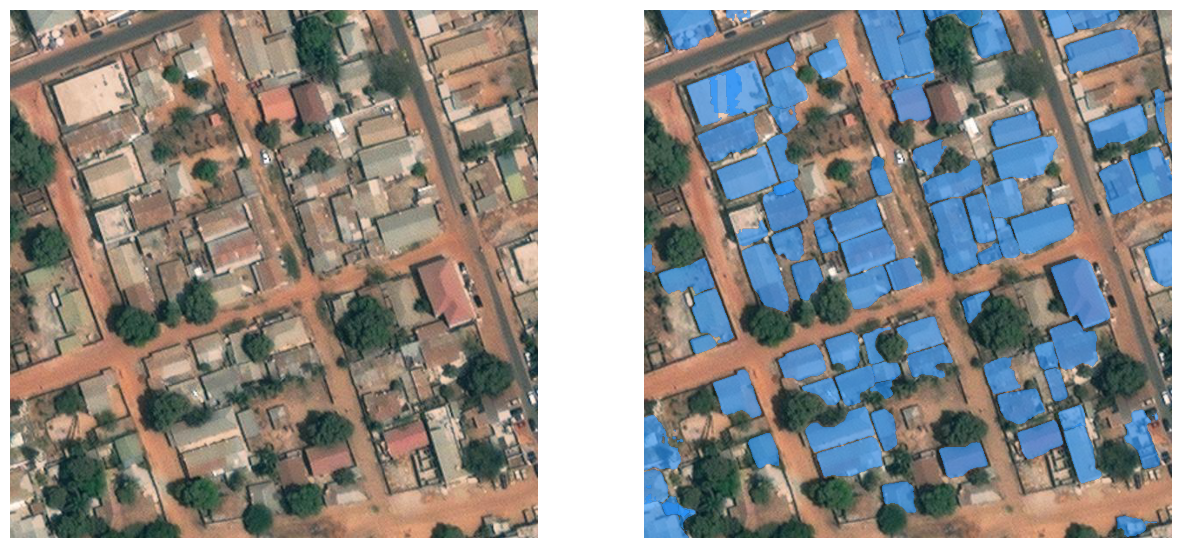

In [15]:
plot_w_wo_masks_SAM(img4Sam, SAMmasks)

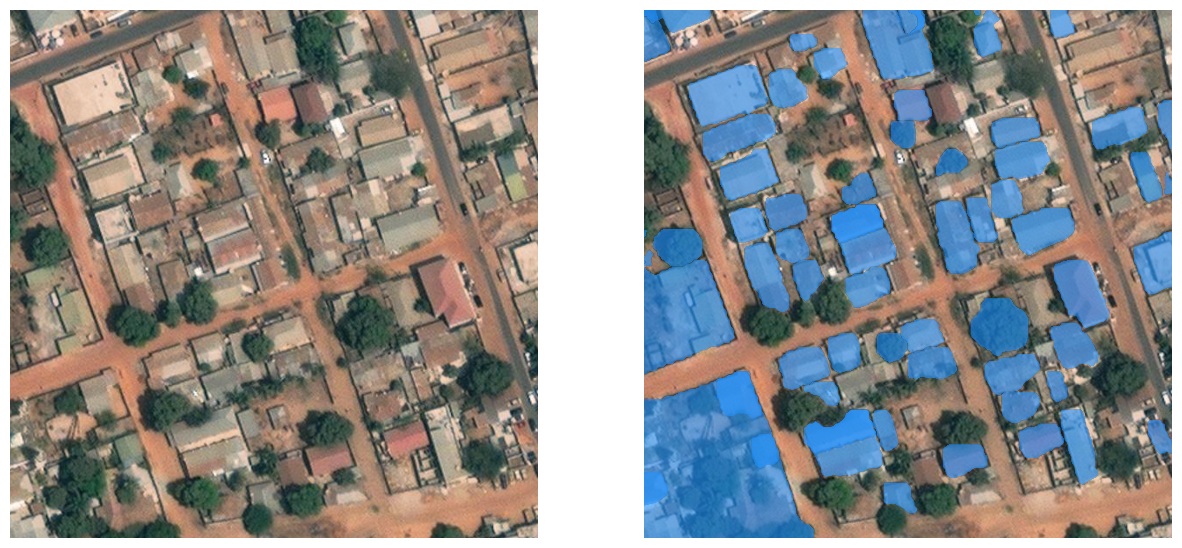

In [16]:
plot_w_wo_masks_FSAM(img4Sam, FSAMmasks)

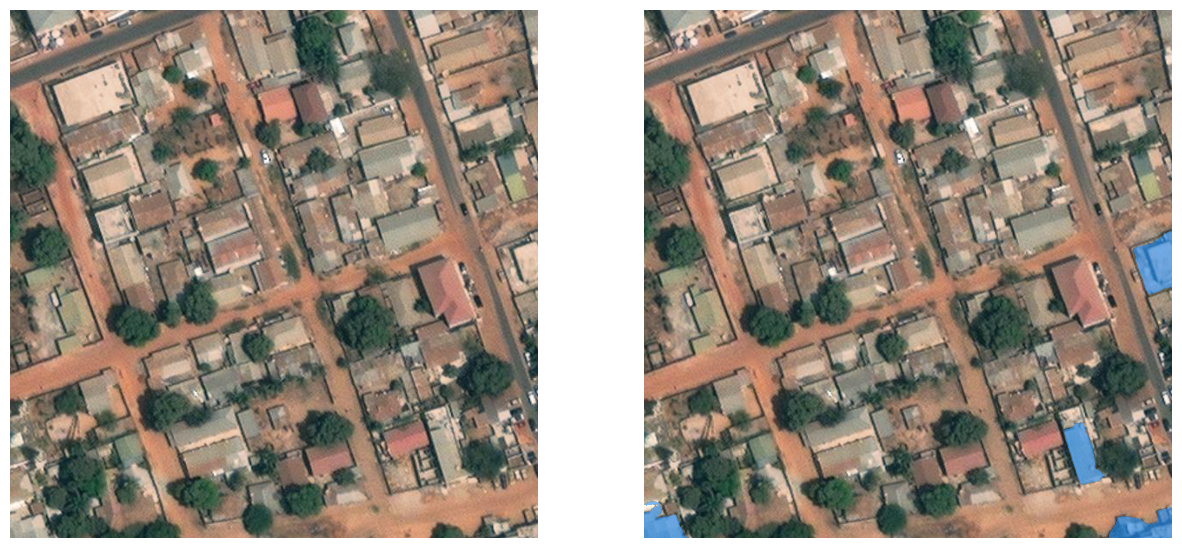

In [22]:
plot_w_wo_masks_ESAM(sample_image_np, ESAM_mask)

In [14]:
def SAMvsFSAMvsESAM(img, SAM_masks, FSAM_masks, ESAM_masks, SAM_time = '', FastSAM_time = '', ESAM_time = ''):
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(2, 3, 2)
    #img
    ax1.imshow(img)
    ax1.set_title('Original')

    #SAM
    ax2 = fig.add_subplot(2, 3, 1, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    #for mask in SAM_masks:
    show_mask(SAM_masks.cpu().numpy().any(axis=0), ax2)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])
    ax2.set_title('SAM: ' + str(round(SAM_time, 2)) + ' (s)')

    #FastSAM
    ax3 = fig.add_subplot(2, 3, 3, sharex=ax1, sharey=ax1)
    ax3.imshow(img)
    #for mask in FSAM_masks:
    show_mask(FSAM_masks.any(axis=0), ax3)
    ax3.set_xlim([0, img.shape[1]])
    ax3.set_ylim([img.shape[0], 0])
    ax3.set_title('FastSAM: ' + str(round(FastSAM_time,2)) + ' (s)')

    #ESAM
    ax4 = fig.add_subplot(2, 3, 5, sharex=ax1)
    ax4.imshow(img)
    show_mask(ESAM_masks, ax4)
    ax4.set_xlim([0, img.shape[1]])
    ax4.set_ylim([img.shape[0], 0])
    ax4.set_title('Efficient SAM: ' + str(round(ESAM_time,2)) + ' (s)')
    
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    plt.subplots_adjust(wspace=0.1, hspace=-0.45)

In [18]:
ESAM_mask.shape

(608,)

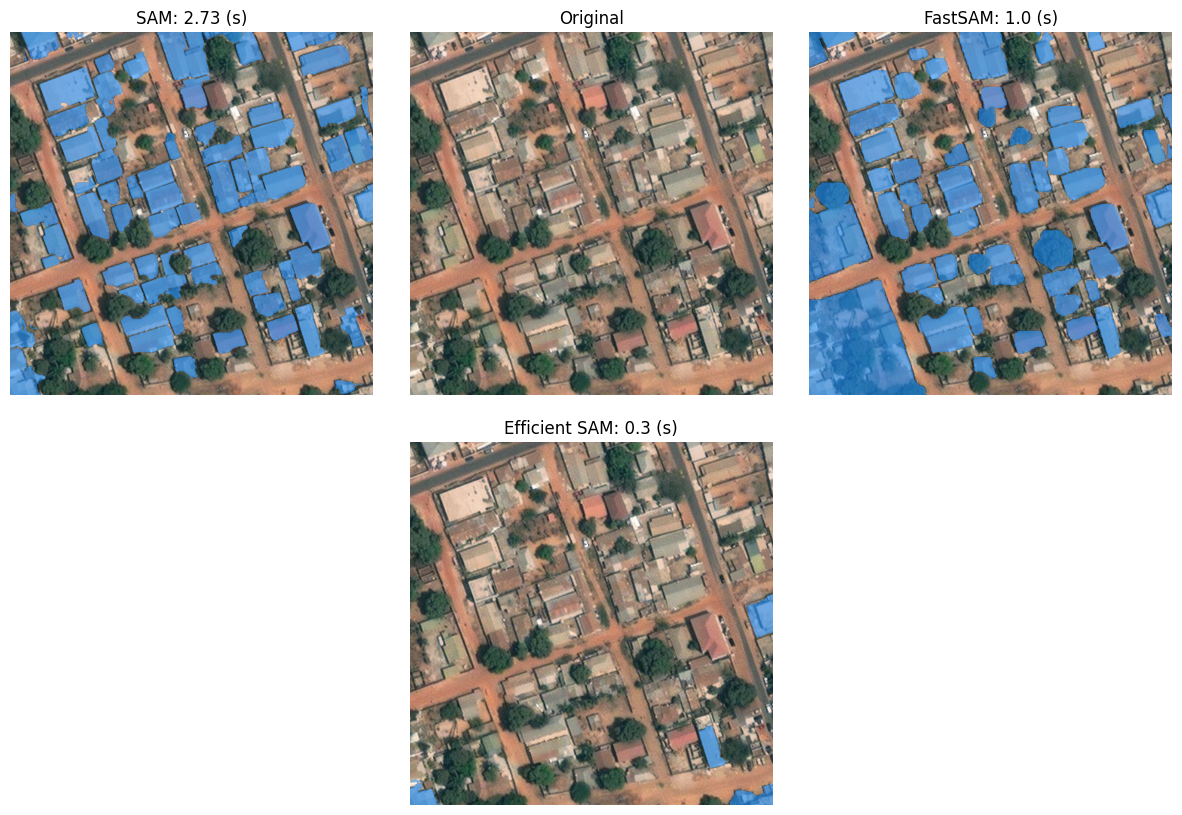

In [21]:
SAMvsFSAMvsESAM(img4Sam, SAMmasks, FSAMmasks, ESAM_mask, SAM_time = t_1_Sam, FastSAM_time = t_1_FastSam, ESAM_time = t_1_ESAM)